## The Need for Clustered and Ordered Datasets

One of the most important ingredients in building a Vecchia GP model is an ordered and clustered dataset. Vecchia models like the Nearest-Neighbor Gaussian Process (NNGP) (Datta, et. al, 2016) demonstrate superior efficiency while maintaining model performance by assuming that an observation in the training set only depends on other observations that are "close" enough to be considered neighbors. However, we cannot simply define these neighbors in terms of Euclidean distance, because the Vecchia approximation further assumes that the dataset is *ordered*, and that only observations that come before a given observation in the ordering can be considered neighbors of that observation. So, the neighbors of an observation depend on the ordering of the dataset. There are many ways to order a dataset for optimal performance, and new ordering schemes are an active area of research.

To complicate things further, some Vecchia models like the Block-Nearest-Neighbor Gaussian Process (BNNGP) (Quiroz, et. al, 2021) generalize the NNGP to assume that non-overlapping *sets of observations* depend on *neighboring sets of observations*. To construct these sets of observations, a variety of spatial clustering (blocking) algorithms have been considered, and the list of sensible choices is always expanding.

With a large and growing number ways to block and order datasets for use in Vecchia models, we do not want to tie your models to a particular clustering algorithm or ordering scheme. Instead, we've built an interface for blocking and ordering functionality that provides a set of sensible defaults, and enables easy customization to users looking to expand on existing blocking and ordering methodologies. To get started, let's dive into the defaults.

## Getting Started

The basic interface for blocking/ordering functionality in this module is the `BaseBlocker` class, from which all other blocking objects must inherit. We'll cover this more when we discuss custom blocking and ordering. For now, let's explore our K-Means implementation of this interface.

### Generating Data

First, we'll load the required libraries.

In [1]:
import gpytorch
import torch
import torch.distributions as distr

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)

Next, we'll generate a simple dataset from a known Gaussian Process.

In [2]:
def f(x):
    
    dist = torch.cdist(x,x)
    cov = 4*torch.exp(-(1/2*(0.1**2)) * dist) + 0.01*torch.eye(len(x))
    distr = torch.distributions.MultivariateNormal(loc = 3*torch.ones(len(x)), covariance_matrix = cov)
    
    return distr.rsample()

In [3]:
sample_size = 2000

# to create sample, first sample N random points from this domain 
x_all = torch.tensor([[x1,x2] for x1,x2 in zip(
    distr.Uniform(torch.tensor([0.0]),torch.tensor([5.0])).rsample(torch.tensor([sample_size])),
    distr.Uniform(torch.tensor([0.0]),torch.tensor([5.0])).rsample(torch.tensor([sample_size])))])

# now apply function to all N points
y_all = f(x_all).float()

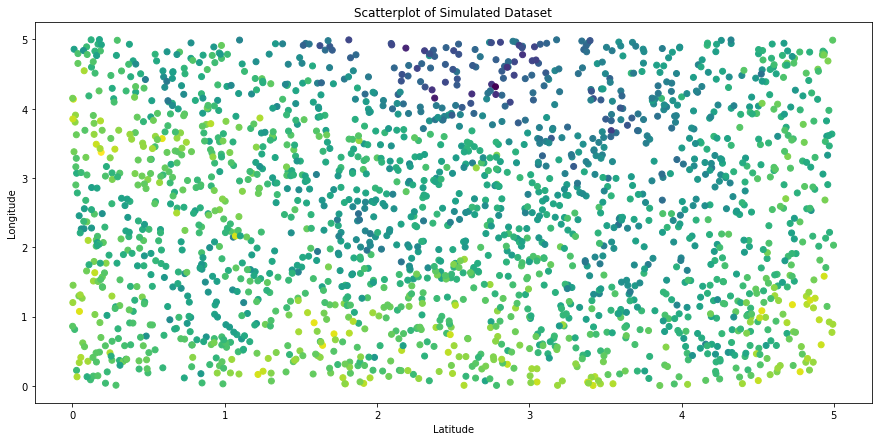

In [4]:
plt.scatter(x_all[:,0].numpy(), x_all[:,1].numpy(), c=y_all)
plt.title("Scatterplot of Simulated Dataset")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Finally, we'll split our dataset into training and testing sets, and we will only use the training set in our blocking object.

In [5]:
idx = torch.randperm(sample_size)
train_idx = idx[0:int(0.8*sample_size)]
test_idx = idx[int(0.8*sample_size):sample_size]

x_train = x_all[train_idx,:]
y_train = y_all[train_idx]

x_test = x_all[test_idx,:]
y_test = y_all[test_idx]

### The K-Means Blocker

Our K-Means blocker can be found in the Vecchia module of GPyTorch, so we will import it from there.

In [6]:
from gpytorch.vecchia import KMeansBlocker

Now, let's use this blocker to implement the NNGP model. In the NNGP model, we only consider singular observations and their neighbors, so want to divide our dataset into as many blocks as there are training observations. This ensures that each observation will belong to its own block. Let's also allow each observation to depend on its 20 nearest neighbors, where the neighbors are defined by Euclidean distance, subject to the ordering constraints discussed above.

In [7]:
kmeans_blocks = KMeansBlocker(x_train, n_blocks=len(x_train), n_neighbors=20)

We can use our built-in plotting method to visualize this object:

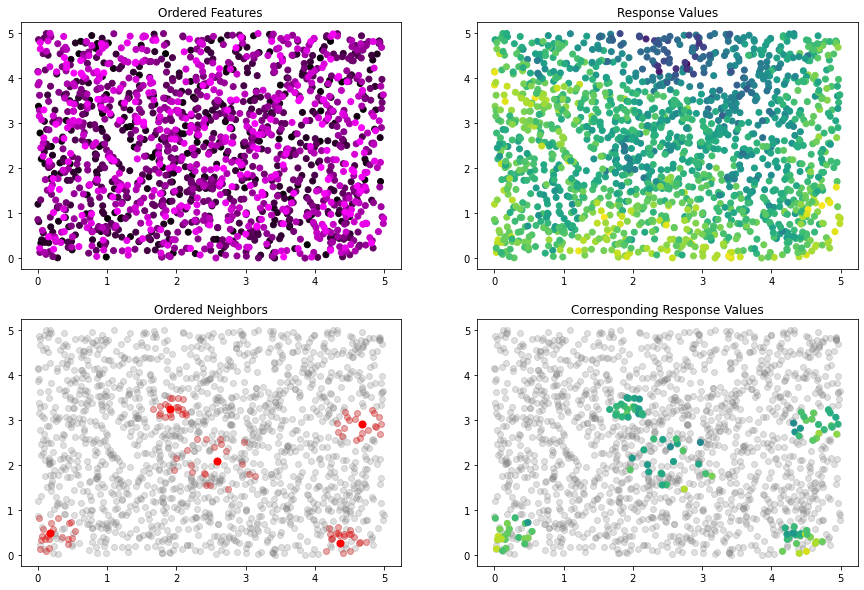

In [12]:
kmeans_blocks.plot(x_train, y_train, n_blocks=5, seed=6543)

At this point, the data is ordered randomly, as the K-Means algorithm that we use does not order the clusters it creates. We can see this random ordering in the *Ordered Features* plot presented above, which colors each point by its index in the dataset. Since the ordering is random, this plot is homogenous.

The `kmeans_blocks` object contains all of the information about our ordered dataset and the neighbor relationships contained within. You can access this information with the `blocks` and `neighbors` properties. Let's look at the first 10 blocks.

In [14]:
kmeans_blocks.blocks[:10]

[tensor([0]),
 tensor([1]),
 tensor([2]),
 tensor([3]),
 tensor([4]),
 tensor([5]),
 tensor([6]),
 tensor([7]),
 tensor([8]),
 tensor([9])]